### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 7
### Due: Saturday, Mar 29th at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

In [1]:
# install the relevant interactive plot packages
# only do this once
!pip install ipywidgets ipympl

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import train_test_split
%config InlineBackend.figure_format='retina'

In [2]:
#1 Loading the Information
info = np.load('./hw_data/hw7_data_1.npy') 

In [33]:
X = info[:,:2]
Label = info[:,2]
yer = info[:,3]

Text(0.5, 0, 'Feature 2')

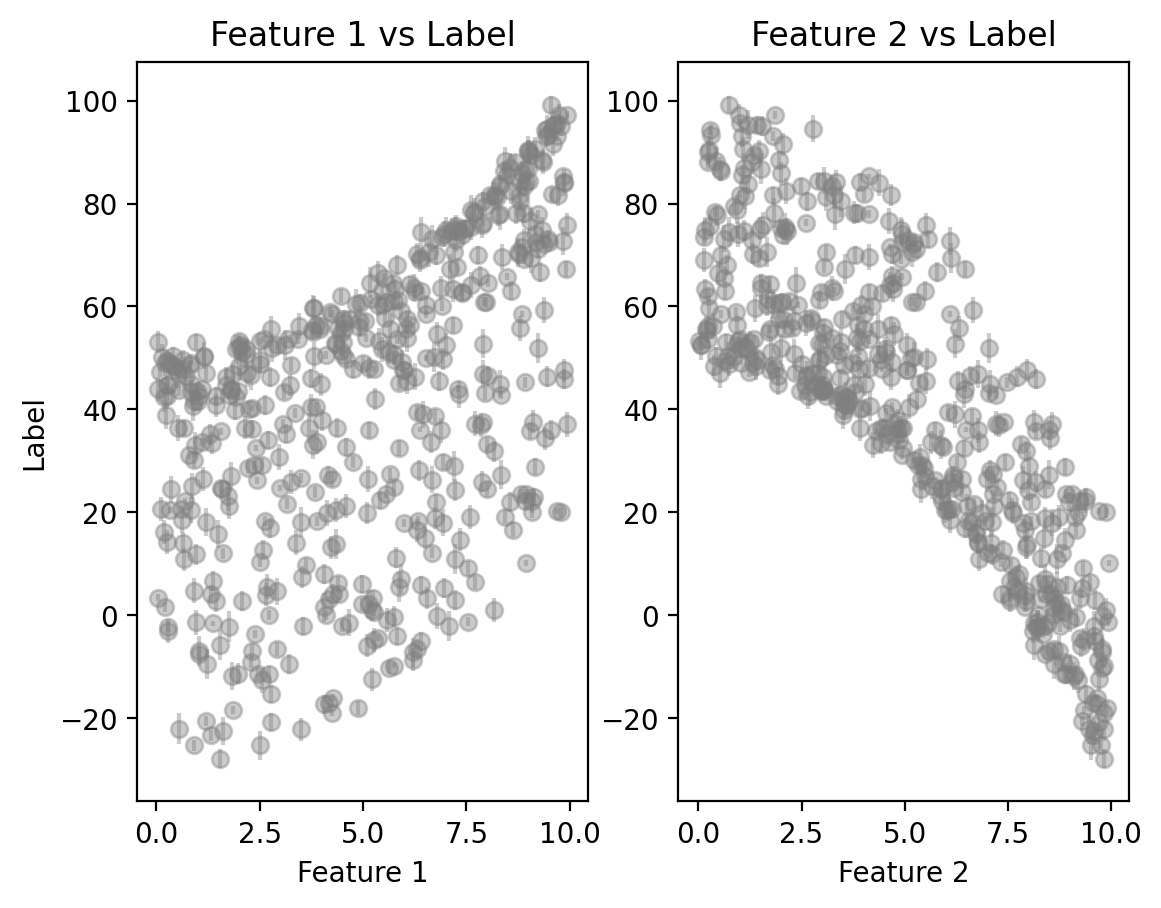

In [269]:
%matplotlib inline

#Creating the two plots
plt.subplot(1,2,1)

#Feature 1
plt.errorbar(X[:,0], Label, yerr=yer, fmt="o", c = "tab:gray", alpha = 0.4) #Low alpha to show regions of high density
plt.ylabel('Label')
plt.title('Feature 1 vs Label')
plt.xlabel("Feature 1")

plt.subplot(1,2,2)

#Feature 2
plt.errorbar(X[:,1], Label, yerr=yer, fmt="o", c = "tab:gray", alpha = 0.4)
plt.title('Feature 2 vs Label')
plt.xlabel("Feature 2")

In [42]:
#2
model = LinearRegression() #Model to use
model.fit(X,Label,yer) #Fitting
print(model.coef_)

[57.10102323  4.94873016 -8.30023407]


SRT: Correct

In [215]:
#2 Cont.
X1 = np.linspace(min(X[:,0]), max(X[:,0]), 50) #Line of numbers that consist of feature 1
X2 = np.linspace(min(X[:,1]), max(X[:,1]), 50) #Same for feature 2
y1 = model.predict(np.array([X1,np.zeros(len(X2))]).T) #Predicts the value of the label given a specific X2 and range of X1
y2 = model.predict(np.array([np.zeros(len(X1)),X2]).T) #Same as before but swaps the values

2500


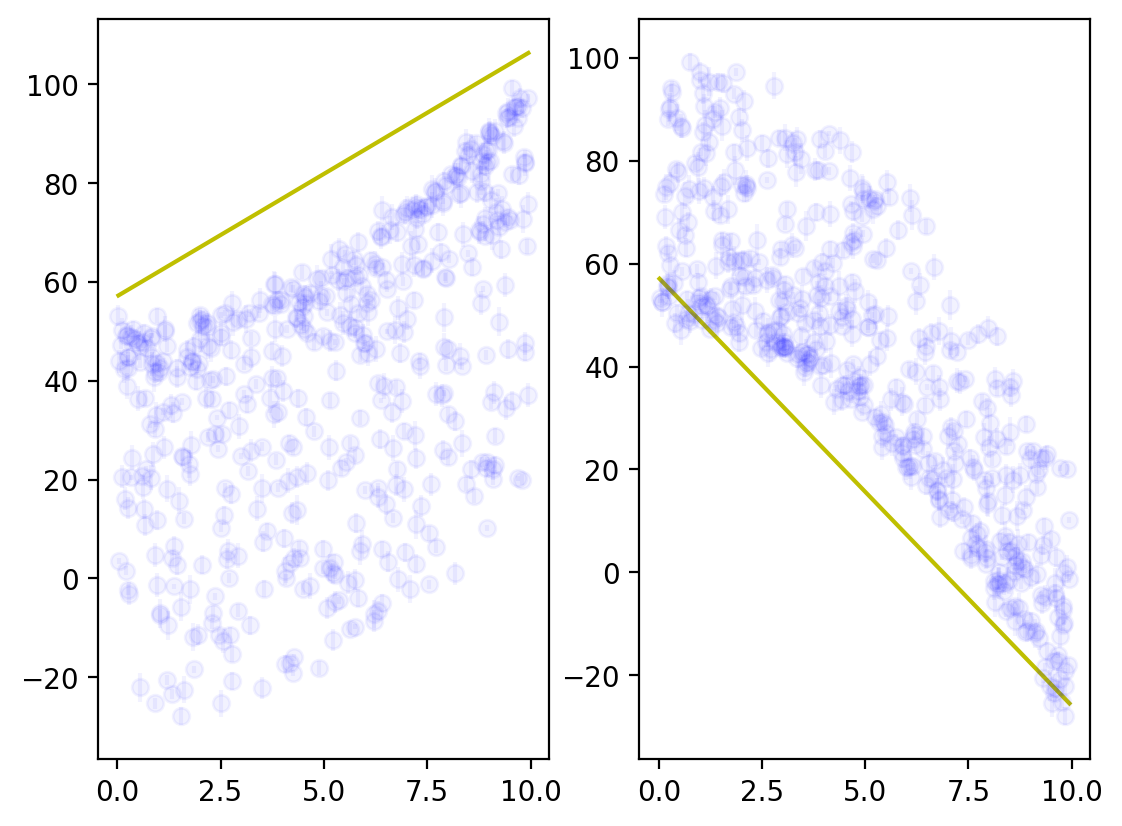

In [271]:
%matplotlib inline

#Turning the data into a plot
plt.subplot(1,2,1)
plt.errorbar(X[:,0], Label, yerr=yer, fmt="o", c = "b", alpha = 0.05) #Lower alpha to show how good the data fits

#Line to plot fit
plt.plot(X1,y1, c = 'y')

plt.subplot(1,2,2)
plt.errorbar(X[:,1], Label, yerr=yer, fmt="o", c = "b", alpha = 0.05)

#Line to plot other fit
plt.plot(X2,y2, c = 'y')

This does not really get at explaining the distribution, and lacks predictive power since it's only one line in an entire 3d distribution.

SRT: Good

In [272]:
#3
X1 = np.linspace(min(X[:,0]), max(X[:,0]), 50) 
X2 = np.linspace(min(X[:,1]), max(X[:,1]), 50)
Xgrid = np.array(np.meshgrid(X1,X2)).T.reshape(-1,2) #Turns the grid into an entire 2 column array consisting of every possibel X1 and X2 combination
Y = model.predict(Xgrid)

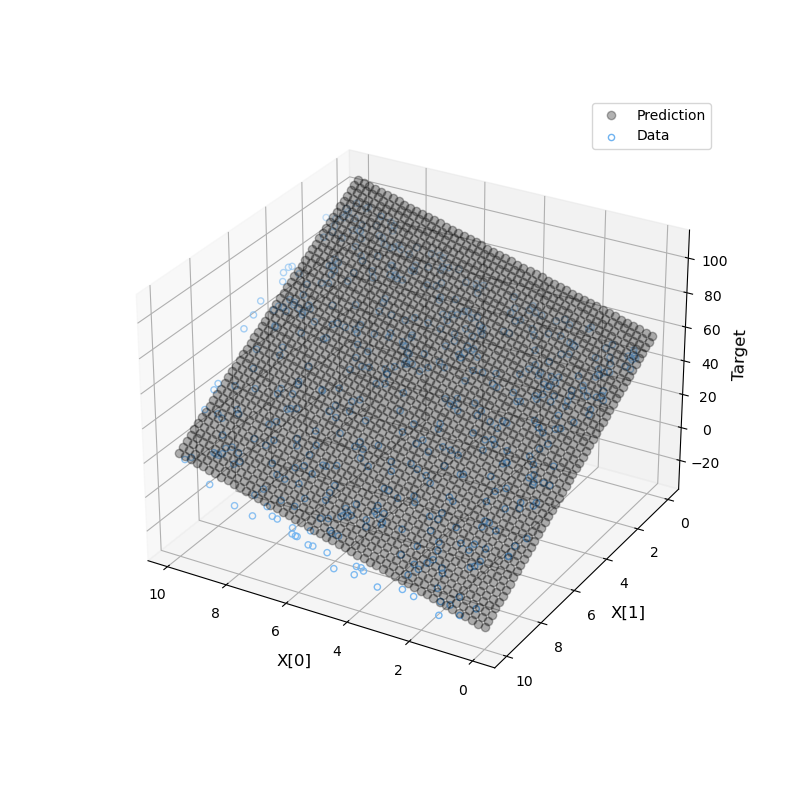

In [273]:
# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], Y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.3, label = "Prediction")
ax.scatter(X[:,0], X[:,1], Label, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0', label = "Data")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)
ax.legend()

Looks nice, but looking around shows that there are still points that don't line up. Additionally the clumping is not the same

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

In [277]:
#4
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']} #Given in question
grid = GridSearchCV(Ridge(),ridge_params)
grid.fit(X,Label, sample_weight=1/yer**2 ) #Fitted based on the data given
print("The following best parameters and score are:")
print(grid.best_params_)
print(grid.best_score_)

The following best parameters and score are:
{'alpha': 1.0, 'solver': 'svd'}
0.929182742615996


In [213]:
model = Ridge(alpha=1, solver = 'svd') #This is the alleged ideal model
model.fit(X,Label,sample_weight=1/yer**2 )
y_pred = model.predict(Xgrid) #Using the same Xgrid out of convenience 

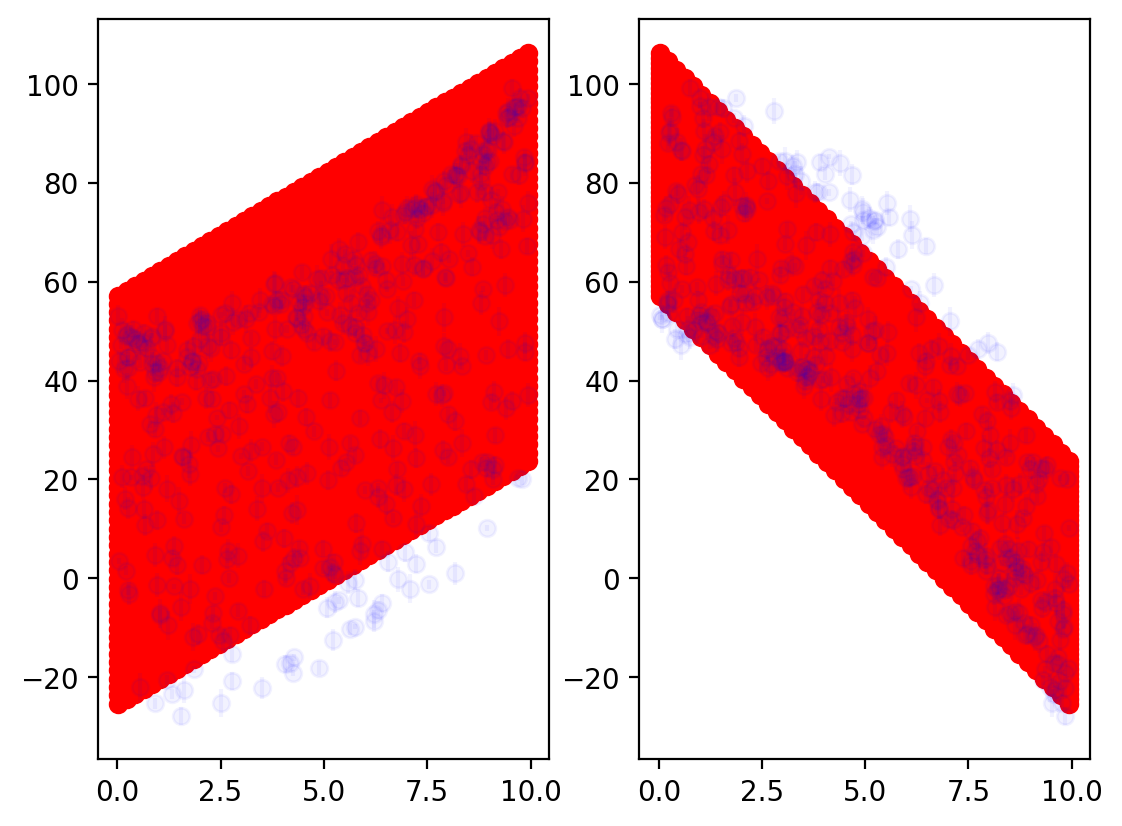

In [255]:
%matplotlib inline
#2D plot first for easy visualization
plt.subplot(1,2,1)
plt.errorbar(X[:,0], Label, yerr=yer, fmt="o", c = "b", alpha = 0.05)
plt.scatter(Xgrid[:,0],y_pred, c = 'red')

plt.subplot(1,2,2)
plt.errorbar(X[:,1], Label, yerr=yer, fmt="o", c = "b", alpha = 0.05)
plt.scatter(Xgrid[:,1],y_pred, c = 'red')


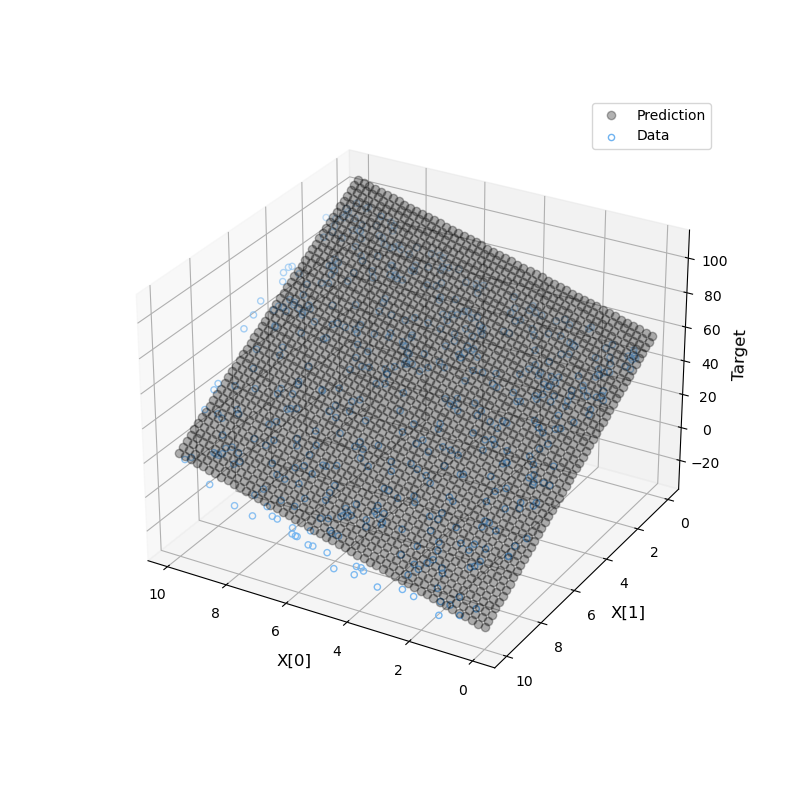

In [256]:
%matplotlib widget 

#3D for more detail now
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], y_pred, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.3, label = "Prediction")
ax.scatter(X[:,0], X[:,1], Label, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0', label = "Data")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)
ax.legend()

In [195]:
#4 Cont.
grip = RidgeCV()
grip.fit(X,Label, sample_weight=1/yer**2 )
print('This is RidgeCV alpha',grip.alpha_, 'This is GridSearch alpha', grid.best_params_)

This is RidgeCV alpha 1.0 This is GridSearch alpha {'alpha': 1.0, 'solver': 'svd'}


Yes it agrees 

SRT: Well done

In [274]:
#5
from sklearn.gaussian_process import GaussianProcessRegressor
gp2 = GaussianProcessRegressor(alpha=(yer / Label) ** 2, random_state=0) #Fitted with a given error
gp2.fit(X,Label)

GaussianProcessRegressor(alpha=array([5.43958419e-04, 3.82759381e-03, 2.60103805e-03, 2.46808730e-03,
       2.65163908e-03, 7.72589348e-04, 1.94817688e-04, 1.67119428e-03,
       6.29160455e-04, 1.53546820e-01, 1.27737611e-03, 4.20743877e-04,
       9.07897153e-04, 1.19348513e-03, 8.23124925e-04, 3.83465716e-04,
       1.52017790e-02, 3.22812075e-04, 3.96160284e+00, 2.98167220e-04,
       4.15652792e-...
       5.38316976e-03, 2.98487981e-03, 7.32974682e-04, 6.94997156e-04,
       5.60561794e-04, 1.10015907e-03, 1.96438887e-03, 5.60292527e-04,
       4.86844042e-04, 3.39426983e-03, 9.75449577e-04, 1.98896826e-03,
       2.24641604e-02, 1.39104618e-03, 2.04290182e-04, 3.06679145e-01,
       7.75266081e-02, 4.07800587e-01, 3.80148249e-03, 1.58631739e-04,
       2.63246735e-03, 2.62188069e-01, 1.18655825e-03, 1.04916023e-02]),
                         random_state=0)

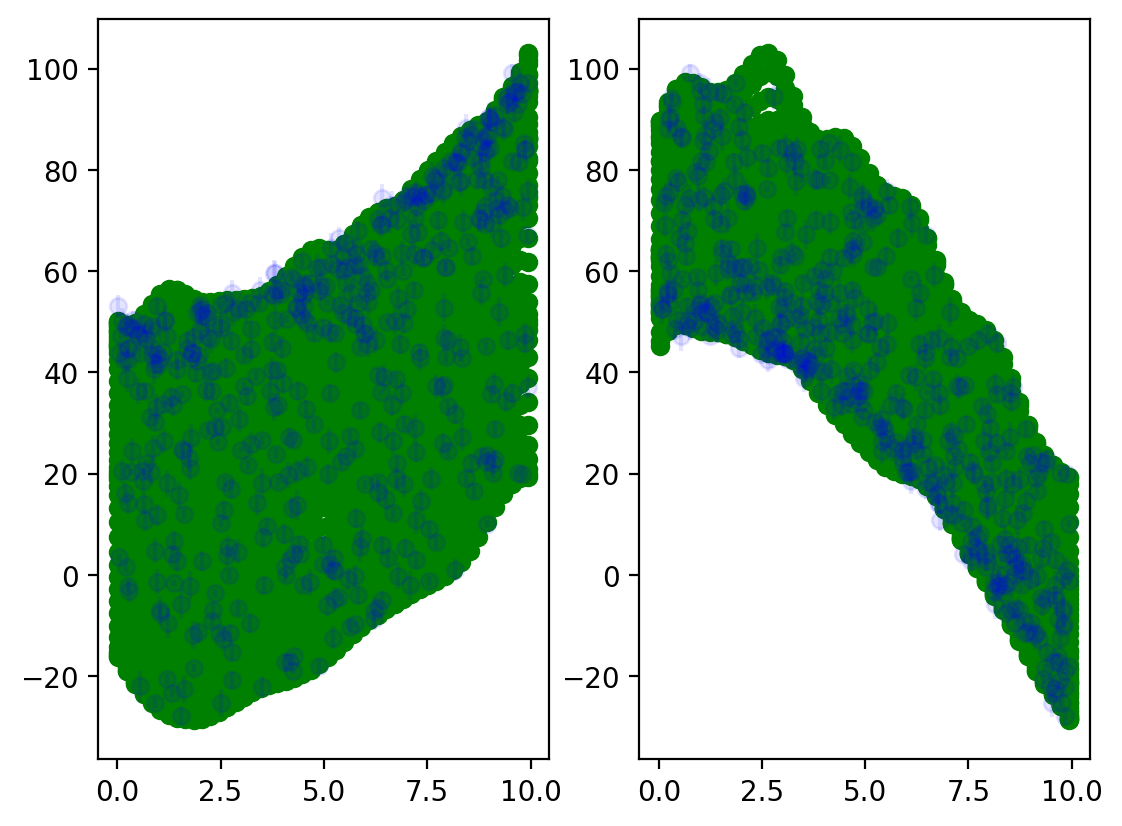

In [275]:
%matplotlib inline
Label_predict=gp2.predict(Xgrid)
plt.subplot(1,2,1)
plt.errorbar(X[:,0], Label, yerr=yer, fmt="o", c = "b", alpha = 0.1)
plt.scatter(Xgrid[:,0],Label_predict, c = 'green')
plt.subplot(1,2,2)
plt.errorbar(X[:,1], Label, yerr=yer, fmt="o", c = "b", alpha = 0.1)
plt.scatter(Xgrid[:,1],Label_predict, c = 'green')

Very wavy looking, but captures all the data

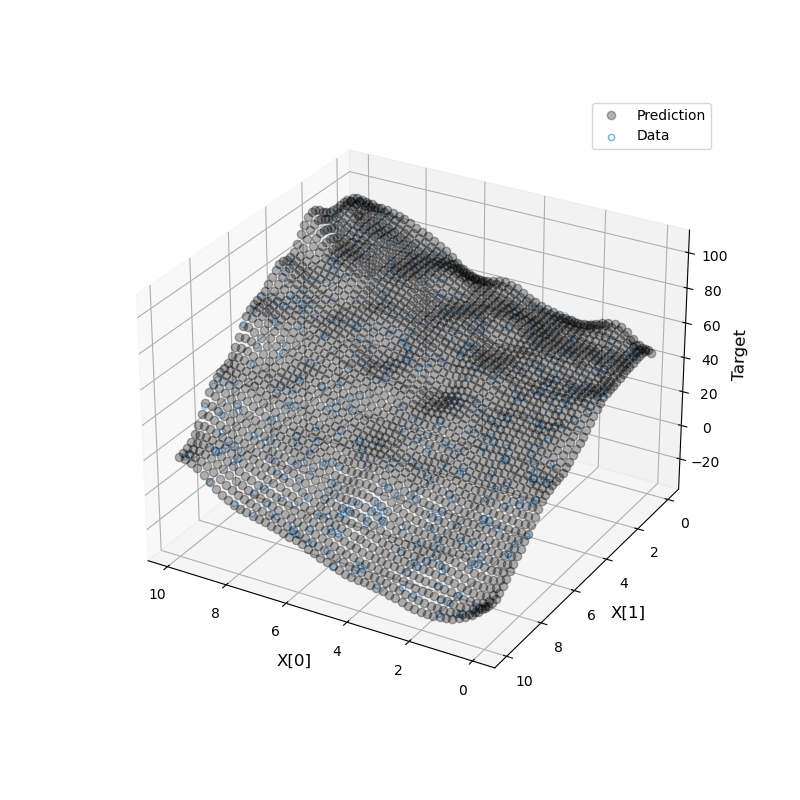

In [257]:
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], Label_predict, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.3, label = "Prediction")
ax.scatter(X[:,0], X[:,1], Label, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0', label = "Data")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)
ax.legend()

Bumpy distribution

In [258]:
gp3 = GaussianProcessRegressor() #No uncertainty given now
gp3.fit(X,Label)
Label_predict1=gp3.predict(Xgrid)

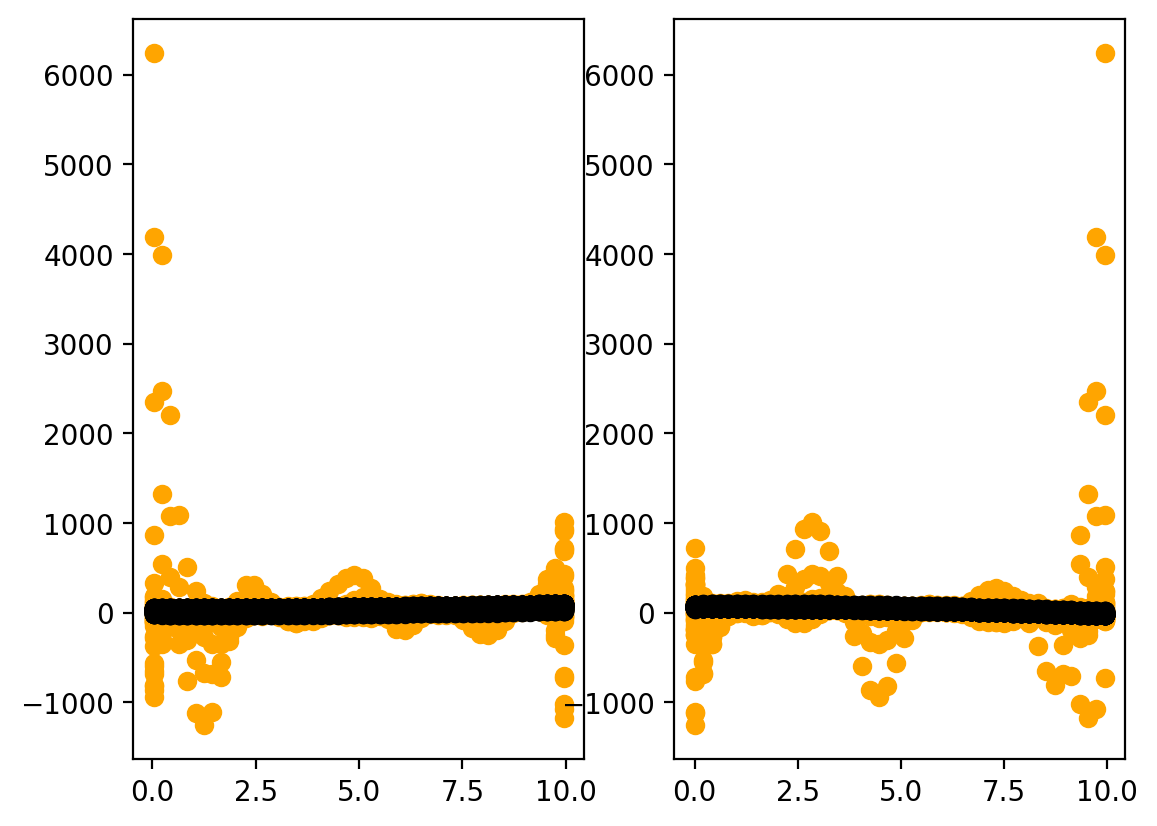

In [259]:
%matplotlib inline
plt.subplot(1,2,1)
plt.scatter(Xgrid[:,0],Label_predict1, c = 'orange')
plt.scatter(Xgrid[:,0],Label_predict, c = 'k')
plt.subplot(1,2,2)
plt.scatter(Xgrid[:,1],Label_predict1, c = 'orange')
plt.scatter(Xgrid[:,1],Label_predict, c = 'k')


Extradorinatly wrong at the endpoints

SRT: Indeed. Taking the uncertainties into account in the GP produces a more controlled fit.

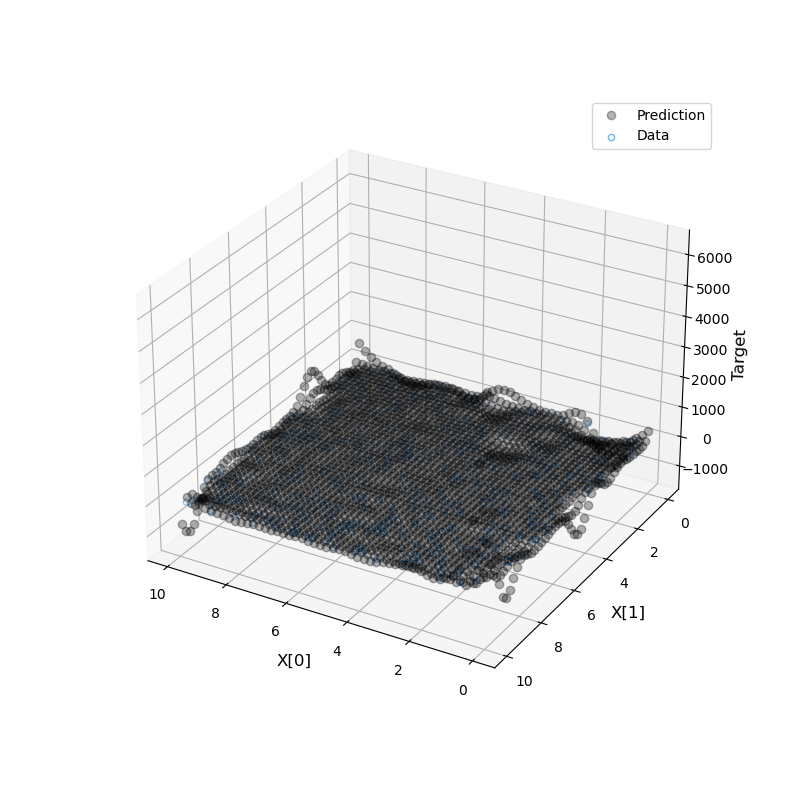

In [228]:
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], Label_predict1, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.3, label = "Prediction")
ax.scatter(X[:,0], X[:,1], Label, facecolor=(0,0,0,0), s=20, edgecolor='#70b3f0', label = "Data")
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)
ax.legend()

The model fails so badly that it makes the initial data look flat in comparision

In [260]:
#6
mod = PolynomialRegression(4) #4th Order
mod.fit(X,Label,yer)
print(mod.coef_)
Lab = mod.predict(Xgrid)

[ 4.99887582e+01  5.54313398e-01 -2.07866484e-01  2.86536907e-01
  2.93842380e-03 -7.82230112e-01  2.47603263e-02  2.45748271e-02
 -2.22233559e-02  9.68417971e-03 -9.95958746e-04 -1.12284370e-03
 -1.14462222e-03  2.10142159e-03 -1.08539159e-03]


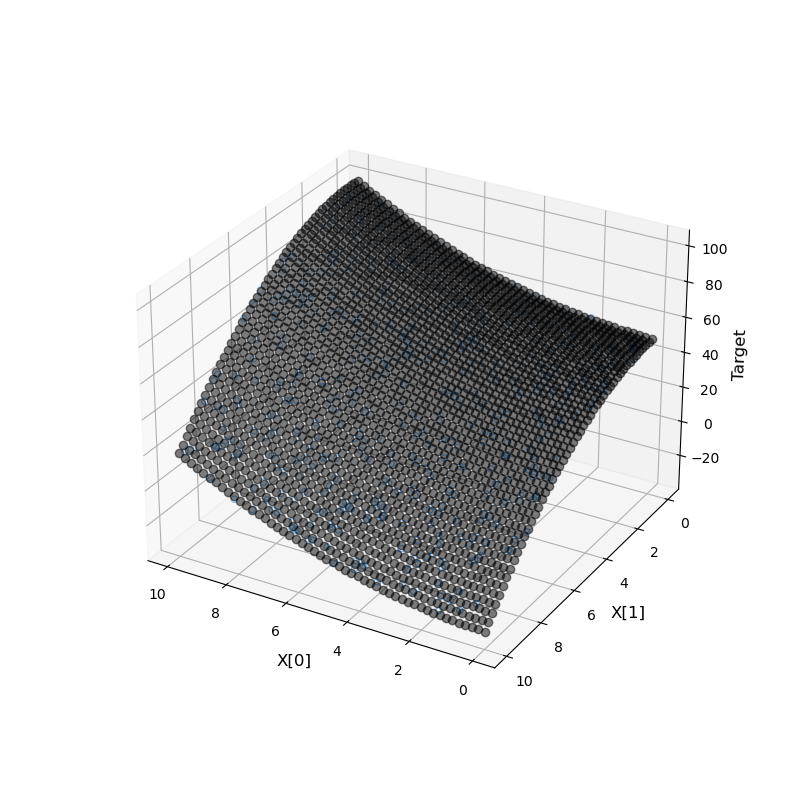

In [261]:
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(Xgrid[:,0], Xgrid[:,1], Lab, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(X[:,0], X[:,1], Label, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

Very good fit

In [262]:
#7
X0Train,X0Test,X1Train,X1Test,YTrain,YTest,ErrTrain,ErrTest = train_test_split(X[:,0],X[:,1],Label,yer,test_size=0.2) #First Split
X0Train1,X0CV,X1Train1,X1CV,YTrain1,YCV,ErrTrain1,ErrCV = train_test_split(X0Train,X1Train,YTrain,ErrTrain,test_size=0.2) #Second Split

In [263]:
#Making the last of the data to test with
#Transpose to get the columns in the right format
XTrain = np.array([X0Train,X1Train]).T
XTrain1 = np.array([X0Train1,X1Train1]).T
XTest = np.array([X0Test,X1Test]).T
XCV = np.array([X0CV,X1CV]).T
YTrain1=np.array(YTrain1)
YCV = np.array(YCV)

In [265]:
d = [1,2,3,4,5,6,7,8,9,10] #Degrees we want to check

#Setting up arrays for  the data
trainrms = [] 
cvrms = []
LikeTrain = []
LikeCV = []

#While loop for all degrees of polynomials
for d_ in d:
    fitter = PolynomialRegression(d_)
    fitter.fit(XTrain1,YTrain1,ErrTrain1)
    Pred = fitter.predict(XTrain1)

    #Root Mean square calculation
    #Append into list for plotting later
    trainrms.append(np.sqrt(np.sum((Pred-YTrain1)**2)/len(YTrain1)))
    LikeTrain.append(np.sqrt(np.sum(((Pred-YTrain1)/ErrTrain1)**2)/len(YTrain1)))

    #Same as before but for the crossvalidation values
    fitter.fit(XCV,YCV,ErrCV)
    Pret = fitter.predict(XCV)
    cvrms.append(np.sqrt(np.sum((Pret-YCV)**2)/len(YCV)))
    LikeCV.append(np.sqrt(np.sum(((Pret-YCV)/ErrCV)**2)/len(YCV)))

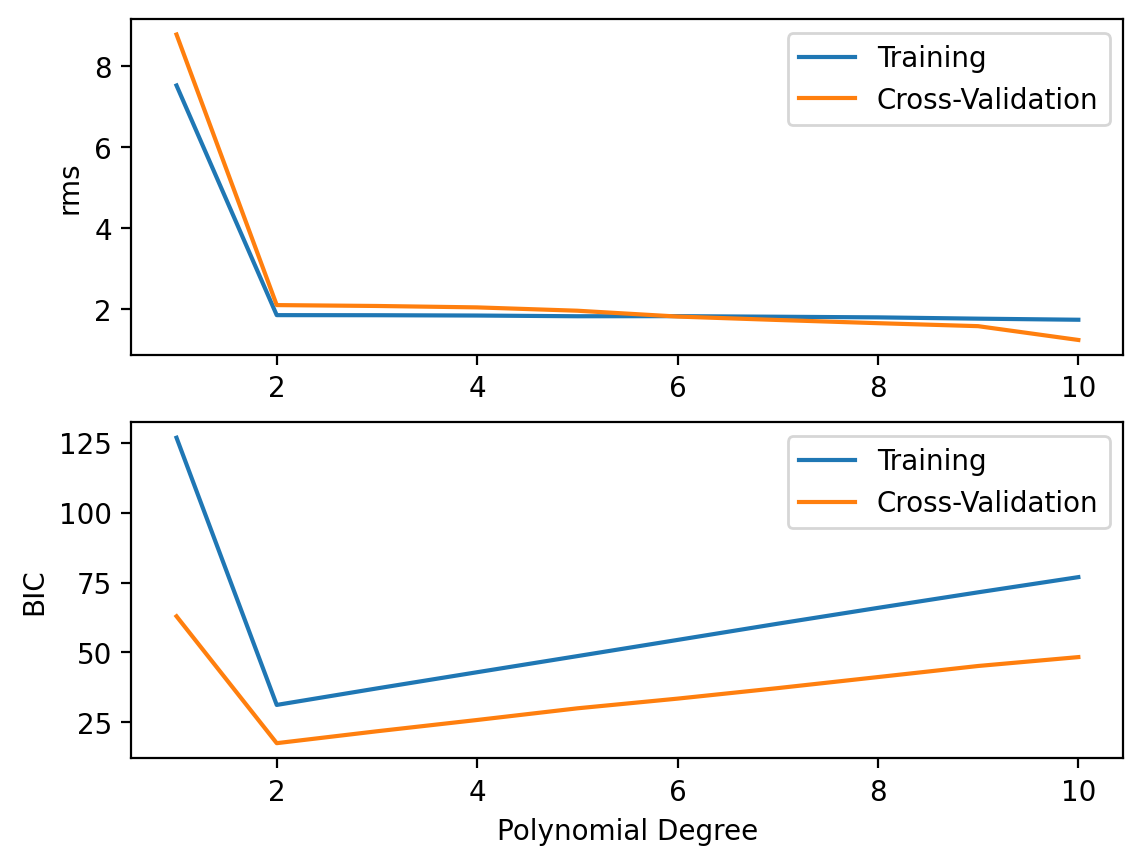

In [266]:
%matplotlib inline
#Calculating the BIC for each polynomial now
BIC_train = np.sqrt(len(YTrain)) * np.array(LikeTrain) + np.array(d) * np.log(len(YTrain))
BIC_crossval = np.sqrt(len(YCV)) * np.array(LikeCV)+ np.array(d) * np.log(len(YCV))

plt.subplot(2,1,1)
plt.plot(d,trainrms, label = 'Training')
plt.plot(d,cvrms, label = "Cross-Validation")
plt.ylabel('rms')
plt.legend()
plt.subplot(2,1,2)
plt.plot(d,BIC_train, label = 'Training')
plt.plot(d,BIC_crossval,label = "Cross-Validation", )
plt.ylabel('BIC')
plt.xlabel('Polynomial Degree')
plt.legend()

The best score comes from 2nd degree polynomial

In [267]:
fitter = PolynomialRegression(2)
fitter.fit(XTrain,YTrain,ErrTrain)
Pred = fitter.predict(XTest)

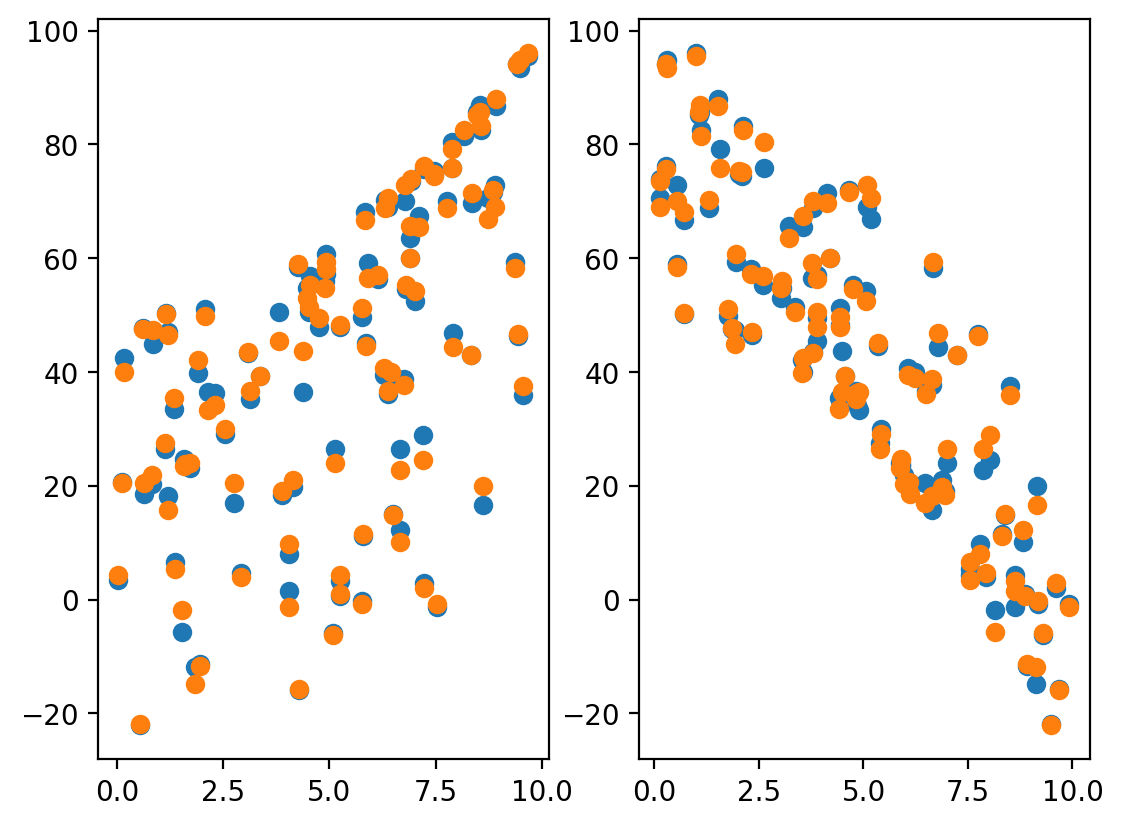

In [280]:
#Just to visualize the prediction
plt.subplot(1,2,1)
plt.scatter(XTest[:,0],YTest)
plt.scatter(XTest[:,0],Pred)
plt.subplot(1,2,2)
plt.scatter(XTest[:,1],Pred)
plt.scatter(XTest[:,1],YTest)

Pretty Good

In [281]:
print('Root mean square is ',np.sqrt(np.sum((Pred-YTest)**2)/len(YTest)))

Root mean square is  1.9419576107928431


Very small root mean square calculated which is pretty good. Note that it does vary in range at times (Makes sense since the distribution is not uniformly deviated so some data may deviate more from the fit than others)

SRT: Matches my solution well. Good job, Noah.

50/50